Processing: 100%|██████████| 14/14 [00:09<00:00,  1.49it/s, Batch Train Loss=0.0433]


Epoch [1/10] Average Train Loss: 0.0605, Average Validation Loss: 0.0518
Validation Loss Decreased (inf --> 0.051842). Saving model...


Processing: 100%|██████████| 14/14 [00:03<00:00,  3.53it/s, Batch Train Loss=0.0270]


Epoch [2/10] Average Train Loss: 0.0340, Average Validation Loss: 0.0520


Processing: 100%|██████████| 14/14 [00:03<00:00,  3.53it/s, Batch Train Loss=0.0261]


Epoch [3/10] Average Train Loss: 0.0309, Average Validation Loss: 0.0467
Validation Loss Decreased (0.051842 --> 0.046737). Saving model...


Processing: 100%|██████████| 14/14 [00:03<00:00,  3.52it/s, Batch Train Loss=0.0288]


Epoch [4/10] Average Train Loss: 0.0292, Average Validation Loss: 0.0290
Validation Loss Decreased (0.046737 --> 0.028965). Saving model...


Processing: 100%|██████████| 14/14 [00:03<00:00,  3.52it/s, Batch Train Loss=0.0290]


Epoch [5/10] Average Train Loss: 0.0295, Average Validation Loss: 0.0290


Processing: 100%|██████████| 14/14 [00:03<00:00,  3.52it/s, Batch Train Loss=0.0309]


Epoch [6/10] Average Train Loss: 0.0291, Average Validation Loss: 0.0294


Processing: 100%|██████████| 14/14 [00:03<00:00,  3.52it/s, Batch Train Loss=0.0294]


Epoch [7/10] Average Train Loss: 0.0289, Average Validation Loss: 0.0274
Validation Loss Decreased (0.028965 --> 0.027399). Saving model...


Processing: 100%|██████████| 14/14 [00:04<00:00,  3.46it/s, Batch Train Loss=0.0206]


Epoch [8/10] Average Train Loss: 0.0266, Average Validation Loss: 0.0271
Validation Loss Decreased (0.027399 --> 0.027105). Saving model...


Processing: 100%|██████████| 14/14 [00:04<00:00,  3.42it/s, Batch Train Loss=0.0254]


Epoch [9/10] Average Train Loss: 0.0272, Average Validation Loss: 0.0256
Validation Loss Decreased (0.027105 --> 0.025625). Saving model...


Processing: 100%|██████████| 14/14 [00:04<00:00,  3.48it/s, Batch Train Loss=0.0241]


Epoch [10/10] Average Train Loss: 0.0265, Average Validation Loss: 0.0239
Validation Loss Decreased (0.025625 --> 0.023855). Saving model...


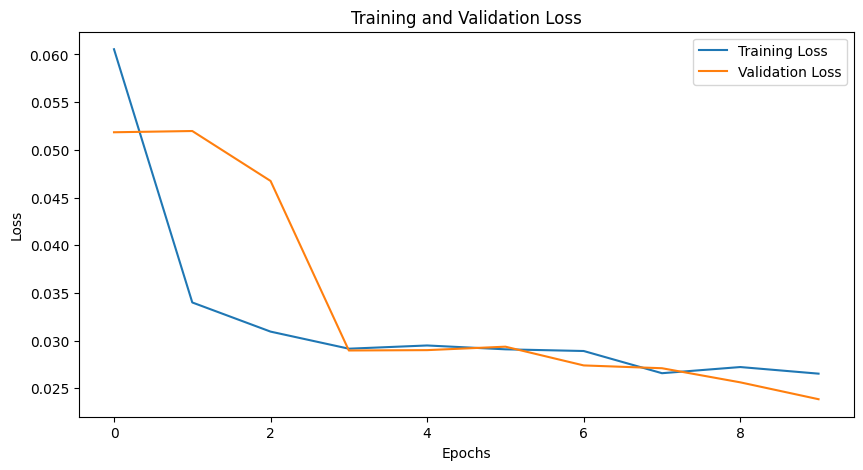

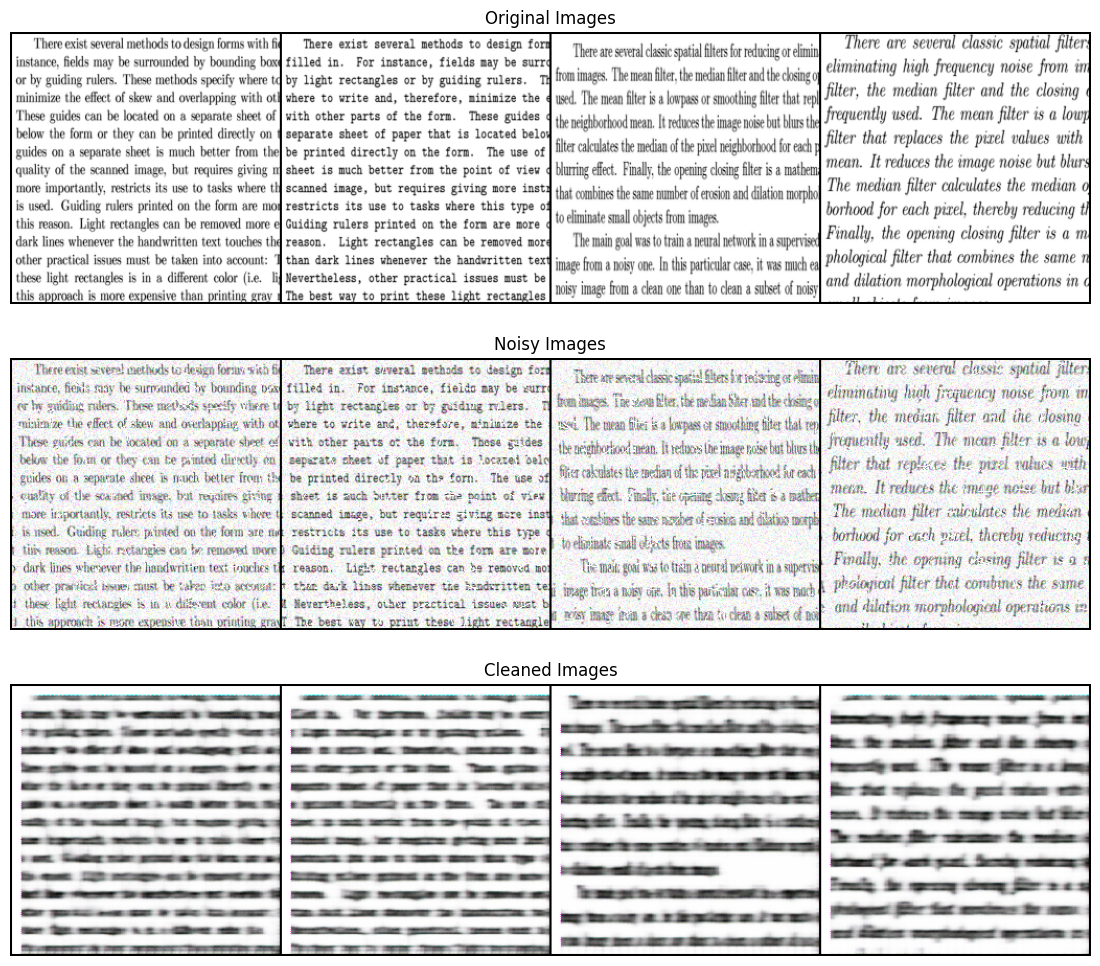

In [4]:
# main.py

import os
from datetime import datetime
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from custom_dataset import CustomImageDataset
from training_functions import train_denoising_model, validate_model
from autoencoders import Autoencoder1
import torch.optim as optim
from tqdm import tqdm
from noise import apply_scanning_artifacts
from visualisation import display_training_results

# Set random seed for reproducibility
torch.manual_seed(0)

# Generate output directory name
output_dir = "output/" + datetime.now().strftime("%Y%m%d-%H%M%S")
os.makedirs(output_dir, exist_ok=True)

# Set environment variables
TRAIN_FUNCTION = train_denoising_model
MODEL = Autoencoder1
EPOCHS = 10
DEVICE = "mps"

# Noise Parameters
NOISE_PARAMS = {
    "noise": 0.1,
    "warp": 0.9,
    "speckle": 0.5,
    "streak": 0.5,
    "rotate": 0.15
}

DATASET_PATH = "/Users/leo/Programming/autoencoder/data/TextImages/train_cleaned"

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

full_dataset = CustomImageDataset(DATASET_PATH, transform=transform)

# Split dataset into train and validation sets
train_size = int(0.75 * len(full_dataset))
valid_size = len(full_dataset) - train_size
train_dataset, valid_dataset = random_split(full_dataset, [train_size, valid_size])

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=8, shuffle=False)

# Initialize model, criterion, and optimizer
model = MODEL().to(DEVICE)
criterion = nn.MSELoss().to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training and Validation
train_losses = []
valid_losses = []
min_valid_loss = float('inf')

for epoch in range(EPOCHS):
    train_loss = 0.0
    pbar = tqdm(enumerate(train_loader), desc="Processing", total=len(train_loader), leave=True)
    for batch_idx, (data, _) in pbar:
        loss = TRAIN_FUNCTION(model, data, NOISE_PARAMS, optimizer, criterion, DEVICE)
        train_loss += loss
        pbar.set_postfix({'Batch Train Loss': f"{loss:.4f}"})

    avg_train_loss = train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    valid_loss = validate_model(model, valid_loader, NOISE_PARAMS, DEVICE)
    valid_losses.append(valid_loss)

    print(f"Epoch [{epoch+1}/{EPOCHS}] Average Train Loss: {avg_train_loss:.4f}, Average Validation Loss: {valid_loss:.4f}")

    # Check if this is the best model (lowest validation loss)
    if valid_loss < min_valid_loss:
        print(f"Validation Loss Decreased ({min_valid_loss:.6f} --> {valid_loss:.6f}). Saving model...")
        min_valid_loss = valid_loss
        torch.save(model.state_dict(), os.path.join(output_dir, "best_model.pth"))

# Display and save training results
display_training_results(train_losses, valid_losses, model, valid_loader, NOISE_PARAMS, DEVICE, output_dir)
